In [11]:
import sys
from pathlib import Path
from tqdm import tqdm

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import compare_ssim
from skimage.measure import compare_psnr

import chainer
import chainer.functions as F

sys.path.append('../experiments/SeqVG/')
from net import Encoder, Decoder, Discriminator
%matplotlib inline

In [12]:
FILE_PATH = Path('.').resolve()
ROOT_PATH = FILE_PATH.parent
RESULT_PATH = ROOT_PATH.joinpath('results/SeqVG')
MODEL_PATH = ROOT_PATH.joinpath('models/SeqVG')
print(FILE_PATH)
print(ROOT_PATH)
print(RESULT_PATH)
print(MODEL_PATH)

/home/shimo/CMULAB/Spatio-Temporal-SR/Notebooks
/home/shimo/CMULAB/Spatio-Temporal-SR
/home/shimo/CMULAB/Spatio-Temporal-SR/results/SeqVG
/home/shimo/CMULAB/Spatio-Temporal-SR/models/SeqVG


In [13]:
test_data = np.load(ROOT_PATH.joinpath('datasets/moving_mnist_test.npy')) \
              .reshape(-1, 20, 1, 64, 64).astype(np.float32) / 255.0
train_data = np.load(ROOT_PATH.joinpath('datasets/moving_mnist_train.npy')) \
               .reshape(-1, 20, 1, 64, 64).astype(np.float32) / 255.0
print(test_data.shape, test_data.dtype, train_data.max())
print(train_data.shape, train_data.dtype, train_data.max())

(1000, 20, 1, 64, 64) float32 1.0
(9000, 20, 1, 64, 64) float32 1.0


In [14]:
encoder = Encoder(64, 1, 100, 8)
decoder = Decoder(64, 1, 100, 8)

model_base_name = "{}_SeqVG_latent{}_ch{}_coef1{}_coef2{}_coef3{}_coef4{}.npz"

chainer.serializers.load_npz(MODEL_PATH.joinpath('mmnist',
    'Encoder_SeqVG_latent100_ch8_coef11.0_coef20.5_coef31.0_coef40.01.npz'), encoder)
chainer.serializers.load_npz(MODEL_PATH.joinpath('mmnist',
    'Decoder_SeqVG_latent100_ch8_coef11.0_coef20.5_coef31.0_coef40.01.npz'), decoder)

## 再構築

In [23]:
x = test_data[:9, 0]
print(x.shape)

with chainer.using_config('train', False), chainer.no_backprop_mode():
        x_rec = decoder(encoder(x)[0]).array \
                .reshape(-1, 64, 64)
print(x_rec.shape, x_rec.max(), x_rec.min(), x_rec.dtype)
x_rec = np.clip(np.array(x_rec)*255, 0, 255).astype(np.uint8)

(9, 1, 64, 64)
(9, 64, 64) 6.340532 -33.055756 float32


(9, 64, 64) 255 uint8


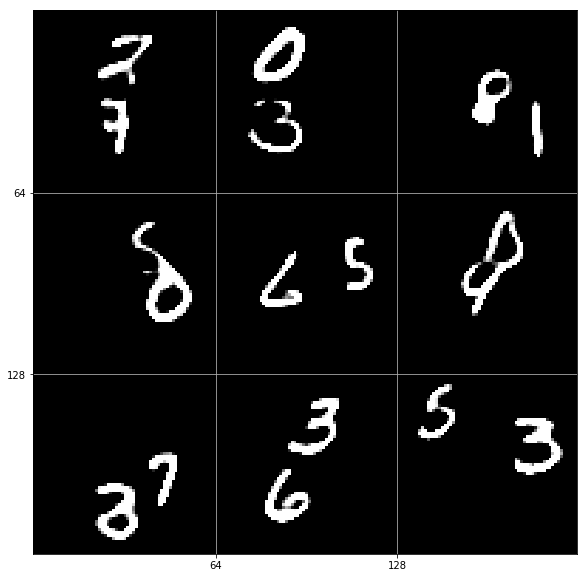

In [25]:
print(x_rec.shape, x_rec.max(), x_rec.dtype)

plt.figure(figsize=(10, 10))
plt.grid(True)
plt.xticks(np.arange(64, 64 * 3, 64))
plt.yticks(np.arange(64, 64 * 3, 64))
plt.imshow(x_rec.reshape(3,3,64,64).transpose(0,2,1,3).reshape(64*3, 64*3), cmap='gray')
plt.imsave('./images/mmnist_seqvaegan_noframe.png', x_rec.reshape(3,3,64,64).transpose(0,2,1,3).reshape(64*3, 64*3), cmap='gray')
plt.savefig('./images/mmnist_seqvaegan.png')
plt.show()

## psnr, ssim評価

In [8]:
# test
psnrs = []
ssims = []

for x_true in tqdm(test_data[:,0]):
    x_true = x_true[np.newaxis, :]
    x_rec = decoder(encoder(x_true)[0]).array
    x_true = np.clip(x_true*255, 0, 255).astype(np.uint8).reshape(64,64)
    x_rec = np.clip(x_rec*255, 0, 255).astype(np.uint8).reshape(64,64)
    psnrs.append(compare_psnr(x_true, x_rec))
    ssims.append(compare_ssim(x_true, x_rec))

print("psnr mean", np.mean(psnrs))
print("ssim mean", np.mean(ssims))

 24%|██▍       | 238/1000 [00:02<00:08, 87.26it/s]


KeyboardInterrupt: 

In [92]:
# train

psnrs = []
ssims = []

for x_true in tqdm(train_data[:,0]):
    x_true = x_true[np.newaxis, :]
    x_rec = decoder(encoder(x_true)[0]).array
    x_true = np.clip(x_true*255, 0, 255).astype(np.uint8).reshape(64,64)
    x_rec = np.clip(x_rec*255, 0, 255).astype(np.uint8).reshape(64,64)
    psnrs.append(compare_psnr(x_true, x_rec))
    ssims.append(compare_ssim(x_true, x_rec))

print("psnr mean", np.mean(psnrs))
print("ssim mean", np.mean(ssims))

100%|██████████| 9000/9000 [02:05<00:00, 71.51it/s]


psnr mean 17.202912867785685
ssim mean 0.8642428171123187


## 連続性評価

In [17]:
num_if = 10
seqs = []

midpoint = np.linspace(0, 1, num_if).astype(np.float32).reshape(num_if, 1, 1)

for i in tqdm(range(10)):
    xs = test_data[i, [0, 1, 2],:]
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        zs = encoder(xs)[0].array
        
        z_01 = zs[0] + np.kron(midpoint, (zs[1] - zs[0]))
        z_12 = zs[1] + np.kron(midpoint, (zs[2] - zs[1]))
        
        x_seq01 = decoder(z_01.reshape(-1, 100)).array
        x_seq12 = decoder(z_12.reshape(-1, 100)).array

    x_seq = np.concatenate((x_seq01, x_seq12[1:]), axis=0) \
                .reshape(-1, 64, 64).transpose(1, 0, 2).reshape(64, -1)

    seqs.append(x_seq)

seqs = np.array(seqs)

100%|██████████| 10/10 [00:00<00:00, 11.62it/s]


In [18]:
seqs.shape, seqs.max(), seqs.min()

((10, 64, 1216), 6.340532, -33.055756)

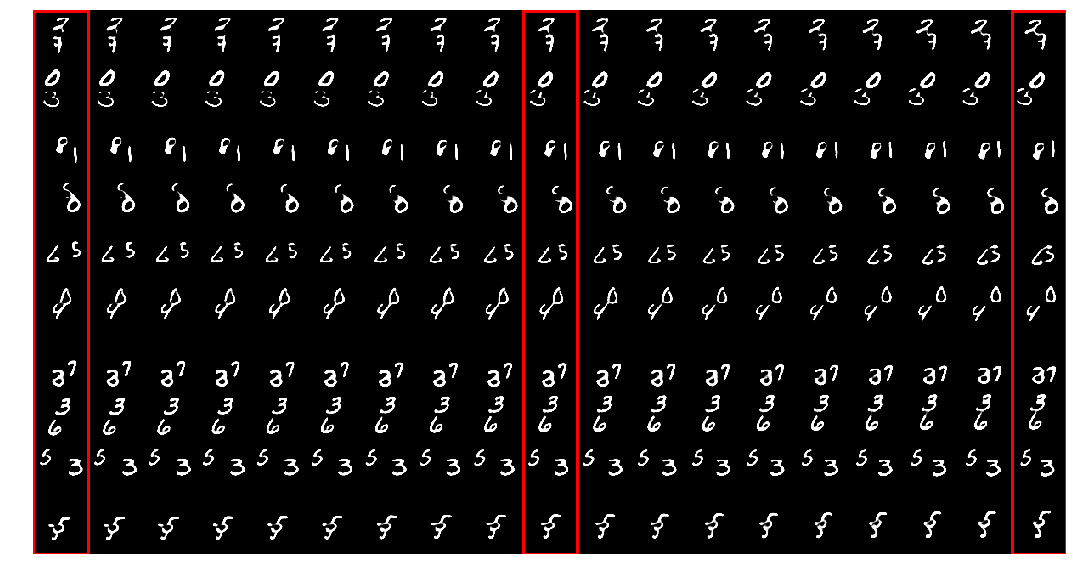

In [26]:
plt.figure(figsize=(20, 10))
plt.imshow(np.clip(seqs*255, 0, 255).reshape(640, 19*64), cmap='gray')
plt.imsave('./images/sequence_seqvaegan_mmnist_noframe.png', np.clip(seqs*255, 0, 255).reshape(640, 19*64), cmap='gray')
# plt.imshow(seqs_u, cmap='gray')

plt.axis('off')
rect = patches.Rectangle(xy=(0,0), width=64, height=640, fill=False, ec="red", linewidth="3.0")
ax = plt.gca().add_patch(rect)
rect = patches.Rectangle(xy=(64*9,0), width=64, height=640, fill=False, ec="red", linewidth="3.0")
ax = plt.gca().add_patch(rect)
rect = patches.Rectangle(xy=(64*18,0), width=64, height=640, fill=False, ec="red", linewidth="3.0")
ax = plt.gca().add_patch(rect)
plt.savefig('./images/sequence_seqvaegan_mmnist.png')
plt.show()